<a href="https://colab.research.google.com/github/samuelshoun/Useful-MWEs/blob/main/reserves_trumpet_plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import some things we don't want to code ourselves
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import seaborn as sns
from scipy import stats

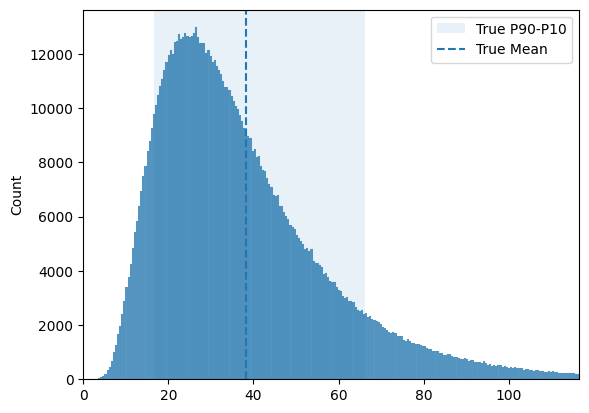

In [2]:
# define a population
# our population will have 1 million data points
# and will be lognormally distributed

population = np.random.lognormal(mean=3.5, sigma=.54, size=1000000)

# display a histogram of the population
xmax = np.quantile(population, .99)  # this is just to set the x-axis limit
sns.histplot(population)
plt.axvspan(*np.quantile(population, q=[.1, .9]), alpha=.1, label='True P90-P10')
plt.axvline(population.mean(), label='True Mean', ls='--')
plt.xlim(0, xmax)
plt.legend();

In [3]:
# this won't matter until later, but let's look at the P10 / P90 ratio
# note that numpy uses non-exceedance, where we expect exceedance quantiles

P10 = np.quantile(population, q=[.9])
P90 = np.quantile(population, q=[.1])

print('P10 / P90 = {:.2f}'.format((P10/P90)[0]))

P10 / P90 = 3.99


In [13]:
# now define a function that samples from the population
# we will tell the function how many data points to sample at a time (n)
# and how many samples to take (m)

def take_samples(data, n=5, m=100): # note that we gave n & m default values
    """
    data:    population data from which samples are taken
    n   :    the number of data points in each sample
    m   :    the number of samples to take

    so, for n = 5 and m = 100, we will take 100 samples, each
    sample consisting of 5 data points from the population.
    """
    # take m samples, each of n count, from the population
    sample = np.random.choice(data, size=(m, n))

    # calculate the mean of each sample
    sample_means = sample.mean(axis=1)

    # calculate the standard deviation of the sample means
    std_sample_means = sample_means.std()

    # output the results in 3 elements
    return sample, sample_means, std_sample_means

In [15]:
# our function outputs 3 elements, so I will assign 3 variables accordingly
s, s_means, s_means_std = take_samples(data=population, n=5, m=100)

In [18]:
# put the sample in a dataframe for easy viewing
df = pd.DataFrame(s)

# you can ignore this step if the code looks unintuitive
# i'm making the dataframe more readable by modifying the index
df.index = ['sample_' + str(i) for i in range(len(df.index))]

# let's also add the sample means to the dataframe
df['sample_mean'] = s_means

# look at the top 5 rows


,0,1,2,3,4,sample_mean
sample_0,20.244181,64.849847,53.531164,105.606460,39.558688,56.758068
sample_1,30.814998,51.398851,52.914027,21.670258,30.707613,37.501149



Standard Dev. of Sample Means: 8.72


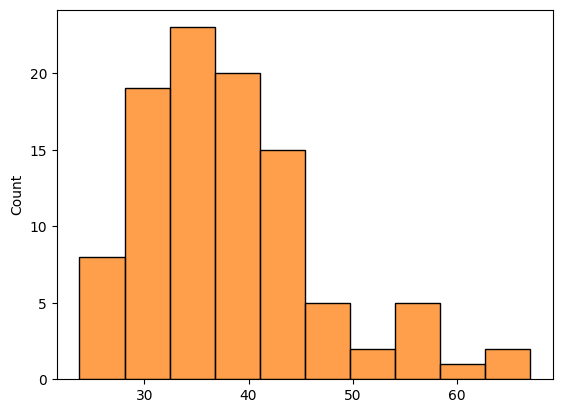

In [19]:
# let's examine a distribution of the sample means
# and the standard deviation of the sample means

print('\nStandard Dev. of Sample Means: {:.2f}'.format(s_means_std))
sns.histplot(s_means, color='C1');

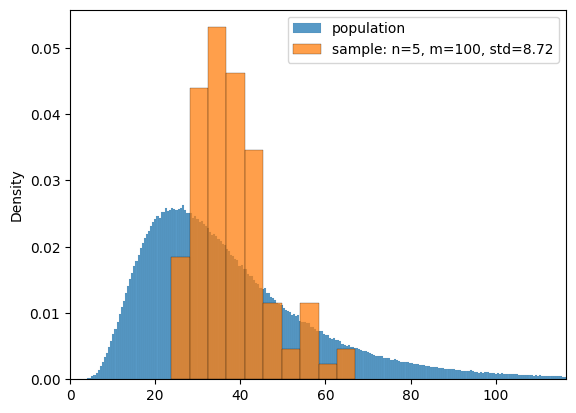

In [20]:
# view the sample next to the population
sns.histplot(population, stat='density', label='population')
sns.histplot(s_means, stat='density', label='sample: n=5, m=100, std={:.2f}'.format(s_means_std))
plt.xlim(0, xmax)
plt.legend();

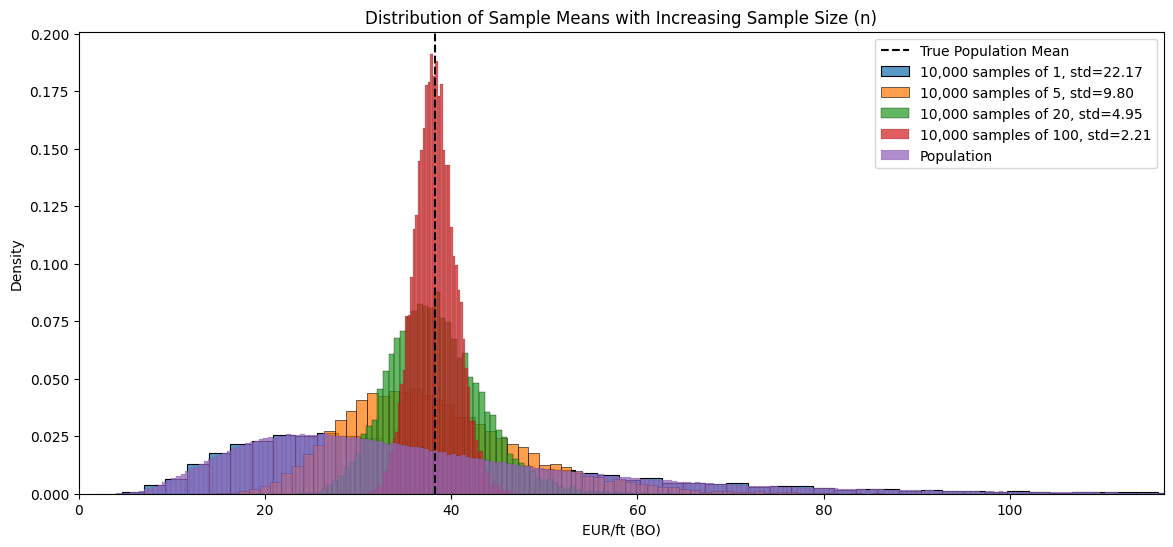

In [23]:
# now let's see what happens as we increase the count (n) in each sample

# make the figure
fig, ax = plt.subplots(figsize=(14,6))

# iterate through the values of n
for i in [1, 5, 20, 100]:
    # sample
    s_i, s_means_i, s_means_std_i = take_samples(population, n=i, m=10000)

    # plot the sample
    sns.histplot(s_means_i, stat='density', label='{:0,g} samples of {:0g}, std={:.2f}'.format(len(s_means_i), i, s_means_std_i))

# plot the population histogram and mark the population mean
sns.histplot(population, stat='density', label='Population')
ax.axvline(population.mean(), color='k', ls='--', label='True Population Mean')

# chart cleanup & labeling
ax.set(xlim=(0, xmax), xlabel='EUR/ft (BO)', title='Distribution of Sample Means with Increasing Sample Size (n)')
ax.legend();

Intuitively, if we take 10,000 samples with 1 well in each sample, the sample means are distributed just like the true population.

In [24]:
# now let's view the same effect using a trumpet plot

# choose the max number of wells in a trial
# this is also approximately the upper limit for the x values in the trumpet plot
n_max = 30

# define an array of trial counts
ns = np.arange(1, n_max+1, 1)

# create a placeholder array that will later hold our quantiles
quantiles = np.zeros(shape=(len(ns), 3))

# loop through the values of n
for n in ns:
    # take sample means
    sample_means = take_samples(population, n=n, m=100000)[1]

    # calculate the quantiles for each value of n
    quantiles_n = np.quantile(sample_means, q=[.9, .5, .1])

    # assign the quantiles to a position in the array
    quantiles[n-1] = quantiles_n

# view quantile values for the first five n values
quantiles[:5]

array([[66.27988758, 33.1713092 , 16.67048156],
       [58.6899234 , 35.39480671, 21.49005493],
       [55.16105907, 36.26160579, 23.93367485],
       [52.93918641, 36.79810114, 25.65388291],
       [51.32701377, 37.03374407, 26.78061181]])

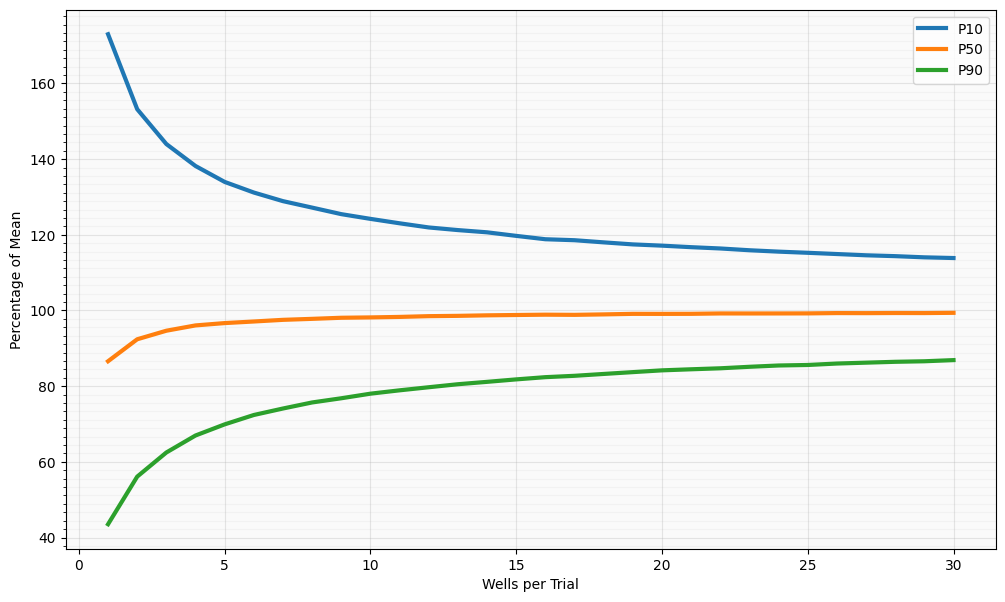

In [25]:
# now we simply plot
fig, ax = plt.subplots(figsize=(12,7), )
fig.gca().yaxis.set_minor_locator(AutoMinorLocator(9))
ax.plot(ns, 100*(quantiles / population.mean()), lw=3)
ax.grid(axis='both', which='major', alpha=.3)
ax.grid(axis='both', which='minor', alpha=.1)
ax.legend(['P10', 'P50', 'P90'])
ax.set(xlabel='Wells per Trial', ylabel='Percentage of Mean', facecolor='lightgray')
ax.patch.set_alpha(.1)

Let's take some time to examine this plot.

Each point on the `x` axis represents 100,000 trials, where each trial takes a random sample of x wells.

So for `x = 5`, we have simulated 100,000 repeated trials of drilling 5 wells. We do this by randomly sampling 5 wells from the population, and taking the average. We repeat this 100,000 times.

On the `y` axis, we examine how much the mean varies by looking at percentiles of those means (P90, P50, and P10).

As we increase the number of wells drilled in each trial, we have more consistent means across those trials. Thus the narrowing range of P10-P90 with increasing `x`.

This is the same effect we see in the histogram comparison above.